# Neural Network Pattern Recognition

## Loading the dataset

First we download the dataset from the provided link:
`https://drive.google.com/drive/folders/1Ca8KOw9LLIZOYeyjgjAiLe43zXDPWBFw`

Download the zip files and put the zipped files in the `data/zips` folder.

the data/zips folder should contain:
- `bearish_spinning_top.zip`
- `bullish_spinning_top.zip`
- `dark_cloud_cover.zip`
- `falling_three.zip`
- `piercing_line.zip`
- `rising_three.zip`
- `three_black_crows.zip`
- `three_white_soldiers.zip`
- `random_pattern.zip`

Now we can unzip the files into a directory called `unzipped`:

In [1]:
import zipfile
import os

output_dir = "data/unzipped"
input_dir = "data/zips"
os.makedirs(output_dir, exist_ok=True)

In [ ]:

for filename in os.listdir(input_dir):
    if filename.endswith(".zip"):
        zip_path = os.path.join(input_dir, filename)
        pattern_dir = os.path.join(output_dir, filename.replace(".zip", ""))
        # Skip if the directory already exists
        if os.path.exists(pattern_dir):
            print(f"Directory {pattern_dir} already exists, skipping extraction.")
            continue
        os.makedirs(pattern_dir, exist_ok=True)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(pattern_dir)


Now let's read the dataset and look at it.

In [2]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


# Get all pattern subfolders
pattern_folders = sorted([
    folder for folder in os.listdir(output_dir)
    if os.path.isdir(os.path.join(output_dir, folder))
])

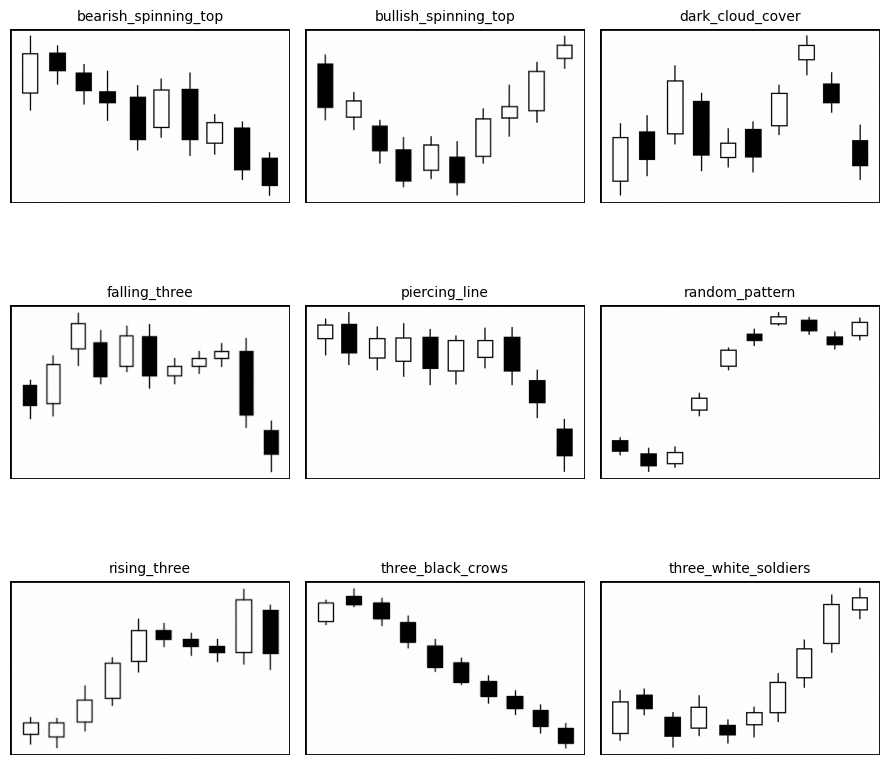

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for ax, pattern in zip(axs.flatten(), pattern_folders[:9]):
    path = os.path.join(output_dir, pattern)
    files = sorted(f for f in os.listdir(path) if f.endswith(".png"))
    try:
        img = Image.open(os.path.join(path, files[0])).convert("RGB")
    except:
        img = np.ones((64, 64, 3))
    ax.imshow(img)
    ax.set_title(pattern, fontsize=10)
    ax.axis("off")
    ax.add_patch(patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes, fill=False, edgecolor='black', linewidth=2))

for ax in axs.flatten()[len(pattern_folders[:9]):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


## Read all the images

In [18]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_dir = "data/unzipped"
output_dir = "data/smaller_dataset"
img_size = (64, 64)
batch_size = 32
max_per_class = 1000

# Step 1: Rebuild a smaller dataset
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)
    selected_images = images[:max_per_class]

    dest_class_dir = os.path.join(output_dir, class_name)
    os.makedirs(dest_class_dir, exist_ok=True)

    for img in selected_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(dest_class_dir, img)
        shutil.copy2(src, dst)

# Step 2: Image generators
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    output_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    output_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 7200 images belonging to 9 classes.
Found 1800 images belonging to 9 classes.


# Model

In [27]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(64, 64, 3)),

    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(train_gen.num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │       262,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,561 (1.02 MB)

 Trainable params: 267,561 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 63s 275ms/step - accuracy: 0.1494 - loss: 2.1999 - val_accuracy: 0.2889 - val_loss: 1.9711
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 58s 256ms/step - accuracy: 0.3026 - loss: 1.9113 - val_accuracy: 0.3094 - val_loss: 1.8502
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 51s 226ms/step - accuracy: 0.3478 - loss: 1.7828 - val_accuracy: 0.3711 - val_loss: 1.7469
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 52s 231ms/step - accuracy: 0.4148 - loss: 1.6262 - val_accuracy: 0.4039 - val_loss: 1.6489
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 214ms/step - accuracy: 0.4588 - loss: 1.4851 - val_accuracy: 0.4350 - val_loss: 1.5646
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 47s 210ms/step - accuracy: 0.5035 - loss: 1.3699 - val_accuracy: 0.4511 - val_loss: 1.5286
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 214ms/step - accuracy: 0.5284 - loss: 1.2815 - val_accuracy: 0.4644 - val_loss: 1.5044
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 49s 219ms/step - accuracy: 0.5540 - loss: 1

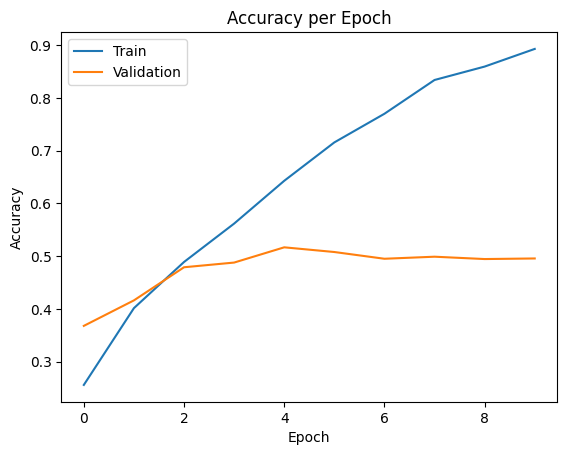

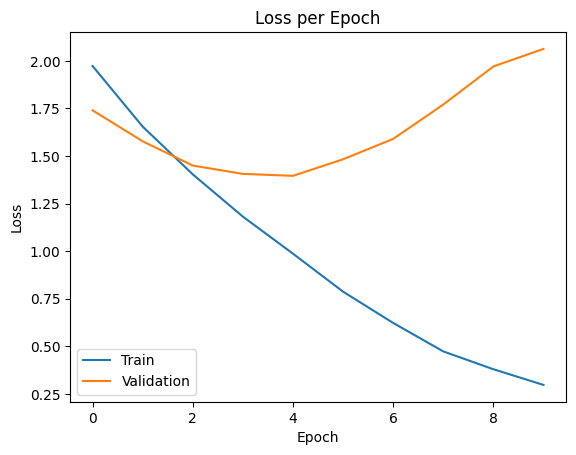

In [21]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [22]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc:.2%}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.4968 - loss: 2.0930
Validation Accuracy: 49.56%


In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions

y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step


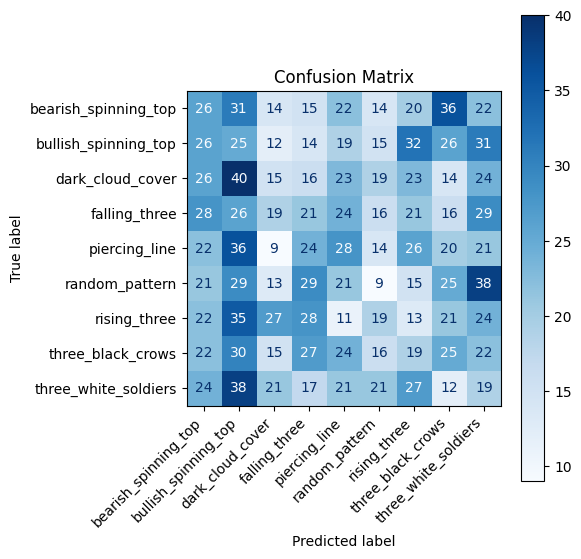

In [25]:
labels = list(val_gen.class_indices.keys())

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)

plt.xticks(rotation=45, ha='right')  # <— horizontal alignment fix
plt.yticks(rotation=0)  # keep y-axis labels straight
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_classes, target_names=labels))